In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from typing import List, Tuple, Optional, Dict
from torch.utils.data import DataLoader, TensorDataset

class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Classifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        """Classifier network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int):
        """Wasserstein critic network."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [2]:
class WDGRLwDiscriminator:
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [20],
        num_classes: int = 2,
        wasserstein_lambda: float = 1.0,
        gradient_penalty_lambda: float = 10.0,
        learning_rate: float = 1e-3,
        critic_learning_rate: float = 1e-3,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        random_seed: Optional[int] = 0
    ):
        """
        Initialize the Wasserstein Domain Adaptation model.
        
        Args:
            input_dim: Dimension of input features
            hidden_dims: List of hidden layer dimensions
            num_classes: Number of classes
            wasserstein_lambda: Weight for Wasserstein distance loss
            gradient_penalty_lambda: Weight for gradient penalty
            learning_rate: Learning rate for generator and classifier
            critic_learning_rate: Learning rate for critic
            device: Device to run the model on ('cuda' or 'cpu')
            random_seed: Random seed for reproducibility
        """
        if random_seed is not None:
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)
            
        self.device = device
        self.wasserstein_lambda = wasserstein_lambda
        self.gradient_penalty_lambda = gradient_penalty_lambda
        
        # Initialize networks
        self.generator = Generator(input_dim, hidden_dims).to(device)
        self.classifier = Classifier(hidden_dims[-1], num_classes).to(device)
        self.critic = Critic(hidden_dims[-1]).to(device)
        
        # Initialize optimizers
        self.gen_cls_optimizer = optim.Adam(
            list(self.generator.parameters()) + 
            list(self.classifier.parameters()),
            lr=learning_rate
        )
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),
            lr=critic_learning_rate
        )
        
        # Loss functions
        self.classification_loss = nn.CrossEntropyLoss()
    
    def compute_gradient_penalty(
        self,
        real_features: torch.Tensor,
        fake_features: torch.Tensor
    ) -> torch.Tensor:
        """Compute gradient penalty for WGAN-GP."""
        batch_size = real_features.size(0)
        alpha = torch.rand(batch_size, 1).to(self.device)
        
        # Interpolated features
        interpolates = alpha * real_features + (1 - alpha) * fake_features
        interpolates.requires_grad_(True)
        
        # Critic output
        disc_interpolates = self.critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(disc_interpolates).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # Compute gradient penalty
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)
    
    def train_step(
        self,
        source_data: torch.Tensor,
        source_labels: torch.Tensor,
        target_data: torch.Tensor,
        critic_steps: int = 100
        ) -> Dict[str, float]:
        """
        Perform one training step.
        
        Args:
            source_data: Input data from source domain
            source_labels: Labels from source domain
            target_data: Input data from target domain
            critic_steps: Number of critic training steps per generator step
            
        Returns:
            Dictionary of loss metrics
        """
        source_data = source_data.to(self.device)
        source_labels = source_labels.to(self.device)
        target_data = target_data.to(self.device)
        
        # Train critic
        for _ in range(critic_steps):
            self.critic_optimizer.zero_grad()
            
            # Generate features
            with torch.no_grad():
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
            
            # Compute Wasserstein distance
            critic_source = self.critic(source_features)
            critic_target = self.critic(target_features)
            wasserstein_dist = torch.mean(critic_source) - torch.mean(critic_target)
            
            # Gradient penalty
            gradient_penalty = self.compute_gradient_penalty(
                source_features.detach(),
                target_features.detach()
            )
            
            # Critic loss
            critic_loss = -wasserstein_dist + self.gradient_penalty_lambda * gradient_penalty
            critic_loss.backward()
            self.critic_optimizer.step()
        
        # Train generator and classifier
        self.gen_cls_optimizer.zero_grad()
        
        # Generate features
        source_features = self.generator(source_data)
        target_features = self.generator(target_data)
        
        # Classification loss
        source_logits = self.classifier(source_features)
        cls_loss = self.classification_loss(source_logits, source_labels)
        
        # Wasserstein distance
        critic_source = self.critic(source_features)
        critic_target = self.critic(target_features)
        wasserstein_dist = torch.mean(critic_source) - torch.mean(critic_target)
        
        # # L2 regularization
        # l2_reg = torch.tensor(0.).to(self.device)
        # for param in self.generator.parameters():
        #     l2_reg += torch.norm(param)
        # for param in self.classifier.parameters():
        #     l2_reg += torch.norm(param)
        
        # Total loss
        total_loss = (
            cls_loss + self.wasserstein_lambda * wasserstein_dist
        )
        
        total_loss.backward()
        self.gen_cls_optimizer.step()
        
        return {
            'classification_loss': cls_loss.item(),
            'wasserstein_distance': wasserstein_dist.item(),
            'gradient_penalty': gradient_penalty.item(),
            'total_loss': total_loss.item()
        }
        
    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> Tuple[float, float]:
        """Evaluate the model on given data."""
        self.generator.eval()
        self.classifier.eval()
        
        total_loss = 0.0
        correct = 0
        total = 0
        
        for data, labels in data_loader:
            data = data.to(self.device)
            labels = labels.to(self.device)
            
            features = self.generator(data)
            logits = self.classifier(features)
            loss = self.classification_loss(logits, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        self.generator.train()
        self.classifier.train()
        
        return total_loss / len(data_loader), correct / total

In [3]:
def create_dataloaders(ns: int = 1000, nt: int = 100, batch_size: int = 64):
    """Create synthetic dataset and dataloaders for domain adaptation."""
    # Create datasets
    xs, ys = make_blobs(ns, centers=[[0, 0], [0, 10]], cluster_std=1)
    xt, yt = make_blobs(nt, centers=[[50, -20], [50, -10]], cluster_std=1)
    
    plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap='viridis', s=2)
    plt.scatter(xt[:, 0], xt[:, 1], c=yt, cmap='cool', s=2)

    # Convert to PyTorch tensors
    xs = torch.FloatTensor(xs)
    ys = torch.LongTensor(ys)
    xt = torch.FloatTensor(xt)
    yt = torch.LongTensor(yt)
    
    # Create datasets
    source_dataset = TensorDataset(xs, ys)
    target_dataset = TensorDataset(xt, yt)
    
    # Create dataloaders
    source_loader = DataLoader(
        source_dataset,
        batch_size=batch_size // 2,
        shuffle=True,
        drop_last=True
    )
    target_loader = DataLoader(
        target_dataset,
        batch_size=batch_size // 2,
        shuffle=True,
        drop_last=True
    )
    
    return source_loader, target_loader

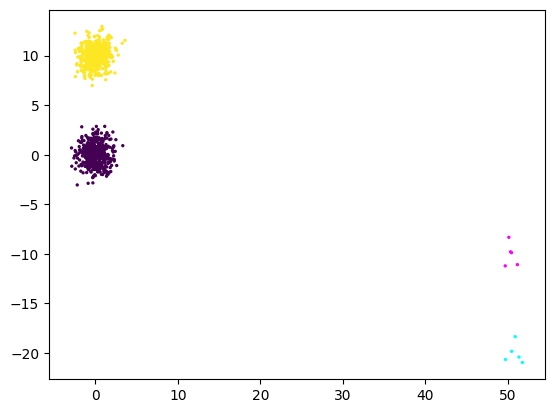

In [4]:
# Training parameters
batch_size = 64
num_epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create dataloaders
source_loader, target_loader = create_dataloaders(ns=1000, nt=10, batch_size=64)

In [5]:
# Create model
model = WDGRLwDiscriminator(
    input_dim=2,
    hidden_dims=[20],
    device=device
)

# Lists to store metrics for plotting
target_accuracies = []
source_accuracies = []
epochs = []

# Training loop
for epoch in range(num_epochs):
    total_metrics = {
        'classification_loss': 0.0,
        'wasserstein_distance': 0.0,
        'gradient_penalty': 0.0,
        'total_loss': 0.0
    }
    num_batches = 0
    
    # Train on all batches
    for (source_data, source_labels), (target_data, target_labels) in zip(source_loader, target_loader):
        metrics = model.train_step(source_data, source_labels, target_data)
        
        for key in total_metrics:
            total_metrics[key] += metrics[key]
        num_batches += 1
    
    # Calculate average metrics for the epoch
    avg_metrics = {
        key: value / num_batches 
        for key, value in total_metrics.items()
    }
    
    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    for name, value in avg_metrics.items():
        print(f"  {name}: {value:.4f}")
    
    # Evaluate on entire source and target datasets
    source_loss, source_acc = model.evaluate(source_loader)
    target_loss, target_acc = model.evaluate(target_loader)
    print(f"  Source Acc: {source_acc:.4f}, Target Acc: {target_acc:.4f}")
    print("-" * 50)
    
    # Store metrics for plotting
    epochs.append(epoch + 1)
    target_accuracies.append(target_acc)
    source_accuracies.append(source_acc)

ZeroDivisionError: float division by zero

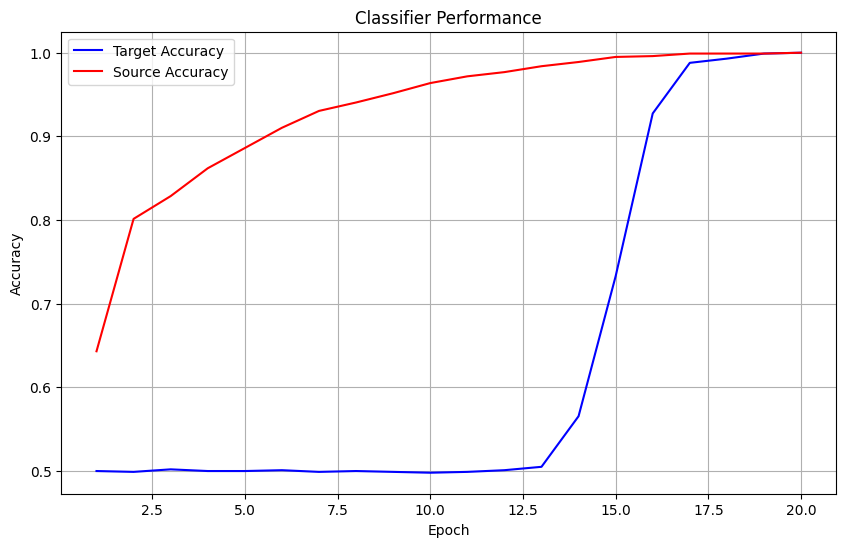

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, target_accuracies, 'b-', label='Target Accuracy')
plt.plot(epochs, source_accuracies, 'r-', label='Source Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier Performance')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
class WDGRL:
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [20],
        gradient_penalty_lambda: float = 10.0,
        learning_rate: float = 1e-3,
        critic_learning_rate: float = 1e-3,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        random_seed: Optional[int] = 0
    ):
        """
        Initialize the Wasserstein Domain Adaptation model.
        
        Args:
            input_dim: Dimension of input features
            hidden_dims: List of hidden layer dimensions
            num_classes: Number of classes
            wasserstein_lambda: Weight for Wasserstein distance loss
            gradient_penalty_lambda: Weight for gradient penalty
            learning_rate: Learning rate for generator and classifier
            critic_learning_rate: Learning rate for critic
            device: Device to run the model on ('cuda' or 'cpu')
            random_seed: Random seed for reproducibility
        """
        if random_seed is not None:
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)
            
        self.device = device
        self.gradient_penalty_lambda = gradient_penalty_lambda
        
        # Initialize networks
        self.generator = Generator(input_dim, hidden_dims).to(device)
        self.critic = Critic(hidden_dims[-1]).to(device)
        
        # Initialize optimizers
        self.gen_optimizer = optim.Adam(
            self.generator.parameters(), 
            lr=learning_rate
        )
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),
            lr=critic_learning_rate
        )
    
    def compute_gradient_penalty(
        self,
        real_features: torch.Tensor,
        fake_features: torch.Tensor
    ) -> torch.Tensor:
        """Compute gradient penalty for WGAN-GP."""
        batch_size = real_features.size(0)
        alpha = torch.rand(batch_size, 1).to(self.device)
        
        # Interpolated features
        interpolates = alpha * real_features + (1 - alpha) * fake_features
        interpolates.requires_grad_(True)
        
        # Critic output
        disc_interpolates = self.critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(disc_interpolates).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # Compute gradient penalty
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)
    
    def train_step(
        self,
        source_data: torch.Tensor,
        target_data: torch.Tensor,
        critic_steps: int = 100
        ) -> Dict[str, float]:
        """
        Perform one training step.
        
        Args:
            source_data: Input data from source domain
            source_labels: Labels from source domain
            target_data: Input data from target domain
            critic_steps: Number of critic training steps per generator step
            
        Returns:
            Dictionary of loss metrics
        """
        source_data = source_data.to(self.device)
        target_data = target_data.to(self.device)
        
        # Train critic
        for _ in range(critic_steps):
            self.critic_optimizer.zero_grad()
            
            # Generate features
            with torch.no_grad():
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
            
            # Compute Wasserstein distance
            critic_source = self.critic(source_features)
            critic_target = self.critic(target_features)
            wasserstein_dist = torch.mean(critic_source) - torch.mean(critic_target)
            
            # Gradient penalty
            gradient_penalty = self.compute_gradient_penalty(
                source_features.detach(),
                target_features.detach()
            )
            
            # Critic loss
            critic_loss = -wasserstein_dist + self.gradient_penalty_lambda * gradient_penalty
            critic_loss.backward()
            self.critic_optimizer.step()
        
        # Train generator
        self.gen_optimizer.zero_grad()
        
        # Generate features
        source_features = self.generator(source_data)
        target_features = self.generator(target_data)
        
        # Wasserstein distance
        critic_source = self.critic(source_features)
        critic_target = self.critic(target_features)
        wasserstein_dist = torch.mean(critic_source) - torch.mean(critic_target)
        
        # # L2 regularization
        # l2_reg = torch.tensor(0.).to(self.device)
        # for param in self.generator.parameters():
        #     l2_reg += torch.norm(param)
        # for param in self.classifier.parameters():
        #     l2_reg += torch.norm(param)
        
        # Total loss
        total_loss = (
            wasserstein_dist
        )
        
        total_loss.backward()
        self.gen_optimizer.step()
        
        return {
            'wasserstein_distance': wasserstein_dist.item(),
            'gradient_penalty': gradient_penalty.item(),
            'total_loss': total_loss.item()
        }
        
    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> Tuple[float]:
        """Evaluate the model on given data."""
        self.generator.eval()
        
        total_critic_score = 0.0
        
        for data, _ in data_loader:
            data = data.to(self.device)

            features = self.generator(data)
            # logits = self.classifier(features)
            # loss = self.classification_loss(logits, labels)
        
            critic_score = torch.mean(self.critic(features))
            
            total_critic_score += critic_score.item()
            
        self.generator.train()

        return total_critic_score / len(data_loader)
    
    @torch.no_grad()
    def predict(self, x: DataLoader) -> torch.Tensor:
        self.generator.eval()
        
        results = self.generator(x)

        self.generator.train()

        return results

In [31]:
# Create model
model2 = WDGRL(
    input_dim=2,
    hidden_dims=[20],
    device=device
)

# Lists to store metrics for plotting
epochs = []
source_losses = []
target_losses = []

# Training loop
for epoch in range(num_epochs):
    total_metrics = {
        'wasserstein_distance': 0.0,
        'gradient_penalty': 0.0,
        'total_loss': 0.0
    }
    num_batches = 0
    
    # Train on all batches
    for (source_data, source_labels), (target_data, target_labels) in zip(source_loader, target_loader):
        metrics = model2.train_step(source_data, target_data)
        
        for key in total_metrics:
            total_metrics[key] += metrics[key]
        num_batches += 1
    
    # Calculate average metrics for the epoch
    avg_metrics = {
        key: value / num_batches 
        for key, value in total_metrics.items()
    }
    
    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    for name, value in avg_metrics.items():
        print(f"  {name}: {value:.4f}")
    
    # Evaluate on entire source and target datasets
    source_loss = model2.evaluate(source_loader)
    target_loss = model2.evaluate(target_loader)
    print(f"  Source Loss: {source_loss:.4f}, Target Loss: {target_loss:.4f}")
    print("-" * 50)
    
    # Store metrics for plotting
    epochs.append(epoch + 1)
    target_losses.append(target_loss)
    source_losses.append(source_loss)

[Linear(in_features=2, out_features=20, bias=True), ReLU()]
Epoch 1/200:
  wasserstein_distance: 121.2776
  gradient_penalty: 3.8999
  total_loss: 121.2776
  Source Loss: 0.1626, Target Loss: -122.1884
--------------------------------------------------
Epoch 2/200:
  wasserstein_distance: 119.2537
  gradient_penalty: 3.9677
  total_loss: 119.2537
  Source Loss: 1.9398, Target Loss: -112.6270
--------------------------------------------------
Epoch 3/200:
  wasserstein_distance: 108.0909
  gradient_penalty: 3.5246
  total_loss: 108.0909
  Source Loss: -0.3740, Target Loss: -102.1622
--------------------------------------------------
Epoch 4/200:
  wasserstein_distance: 97.9342
  gradient_penalty: 3.1266
  total_loss: 97.9342
  Source Loss: -0.2349, Target Loss: -91.9724
--------------------------------------------------
Epoch 5/200:
  wasserstein_distance: 88.7975
  gradient_penalty: 2.7754
  total_loss: 88.7975
  Source Loss: 0.3607, Target Loss: -84.7843
------------------------------

KeyboardInterrupt: 

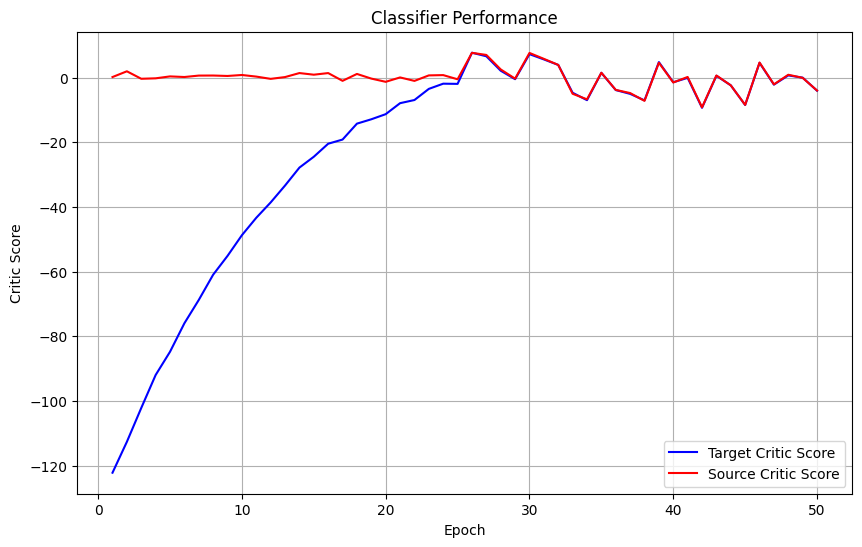

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, target_losses, 'b-', label='Target Critic Score')
plt.plot(epochs, source_losses, 'r-', label='Source Critic Score')
plt.xlabel('Epoch')
plt.ylabel('Critic Score')
plt.title('Classifier Performance')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
class FeatureClassifier:
    def __init__(
        self,
        feature_dim: int,
        num_classes: int,
        learning_rate: float = 1e-3,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.device = device
            
        self.classifier = Classifier(feature_dim, num_classes).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        
    def train_epoch(self, train_loader: DataLoader) -> float:
        """Train for one epoch"""
        self.classifier.train()
        total_loss = 0.0
        total_samples = 0
        
        for features, labels in train_loader:
            features = features.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.classifier(features)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            self.optimizer.step()
            
            batch_size = features.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
        return total_loss / total_samples
    
    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Evaluate the model"""
        self.classifier.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        for features, labels in val_loader:
            features = features.to(self.device)
            labels = labels.to(self.device)
            
            outputs = self.classifier(features)
            loss = self.criterion(outputs, labels)
            
            predictions = torch.argmax(outputs, dim=1)
            correct = (predictions == labels).sum().item()
            
            batch_size = features.size(0)
            total_loss += loss.item() * batch_size
            total_correct += correct
            total_samples += batch_size
            
        avg_loss = total_loss / total_samples
        accuracy = total_correct / total_samples
        return avg_loss, accuracy
    
    @torch.no_grad()
    def predict(self, features: torch.Tensor) -> torch.Tensor:
        """Predict class probabilities for features"""
        self.classifier.eval()
        features = features.to(self.device)
        logits = self.classifier(features)
        return logits